# GripPrint
- Unique "fingerprint" based on how users grip and interact with the dualsense controller.


### Model 1 Minimuan validation model- ontable or onhand


#### Collect data

In [1]:
# define a function to check the connection of the dualsense controller
import pydualsense as ds

def check_controller_connection():
    try:
        dualsense = ds.pydualsense()
        # Try to find and open the device
        device = dualsense._pydualsense__find_device()  # Access private method with name mangling
        if device:
            print("✅ Controller connected")
            connected = True
        else:
            print("❌ Controller not connected")
            connected = False
            
    except Exception as e:
        print("❌ Controller not connected")
        connected = False
    finally:
        if 'device' in locals():
            try:
                device.close()
            except:
                pass
    
    return connected



print("Is the controller connected?", check_controller_connection())

✅ Controller connected
Is the controller connected? True


In [11]:
# define a function to collect data from the dualsense controller with two labels: ontable and onhand
# save the data to a csv file

import os
import time
import pandas as pd
import pydualsense as ds

table_colunm=["timestamp", "gyroscope_pitch", "gyroscope_yaw", "gyroscope_roll", "accelerometer_x", "accelerometer_y", "accelerometer_z", "session_id", "label"]


def simple_data_collection(label: str, session_count: int = 500, collection_duration: int = 100000, csvfile_name:str="Simple_data.csv"):
    # parameters:
    # label: the label of the data collection
    # session_time: the time segment of the data collection in milliseconds
    # collection_duration: the duration of the data collection in milliseconds

    dualsense = ds.pydualsense()
    dualsense.init()    

    #  get the timestamp of the data collection
    timestamp = time.time()

    #  get the inertial data from the dualsense controller
    inertial_data = []
    start_time = time.time()
    session_id = int(time.time())  # Initial session_id
    data_count = 0  # Counter for collected data points
    
    while (time.time() - start_time) * 1000 < collection_duration:
        current_time = time.time()
        
        # Get sensor data from dualsense
        gyro = dualsense.state.gyro
        accel = dualsense.state.accelerometer
        
        # Create a data point
        data_point = [
            current_time,
            gyro.Pitch, gyro.Yaw, gyro.Roll,
            accel.X, accel.Y, accel.Z,
            session_id,
            label
        ]

        # update the data point in the console in one line 
        print(f"Data points: {data_count}, Session ID: {session_id}, Data: {data_point}", end='\r')

        #  append the data point to the inertial data
        inertial_data.append(data_point)
        
        # Increment data counter and update session_id every 500 data points
        data_count += 1
        if data_count % session_count == 0:
            session_id += 1
            
        time.sleep(0.001)  # Small delay to prevent overwhelming the controller
    
    #  save the inertial data to a csv file
    df = pd.DataFrame(inertial_data, columns=table_colunm)
    
    

 
    # Use csvfile_name as the target file
    if os.path.exists(csvfile_name):
        # Append data without header
        df.to_csv(csvfile_name, mode='a', header=False, index=False)
        print(f'Data appended to existing {csvfile_name}')
    else:
        # Create new file with header
        df.to_csv(csvfile_name, index=False)
        print(f'New file {csvfile_name} created')

    dualsense.close()


# define a function to start the invoke the simple_data_collection 
# Second cell - Define the function
def collect_both_positions():
    file_index=int(time.time())
    csvfile_name=f"sample_data{file_index}.csv"
    # First collection - Table position
    input("Press Enter when ready to collect data for TABLE position (controller flat on table)...")
    print("Starting data collection for TABLE position in 3 seconds...")
    time.sleep(1)
    print("2...")
    time.sleep(1)
    print("1...")
    time.sleep(1)
    print("Recording...")
    simple_data_collection(label='table' ,csvfile_name=csvfile_name)
    print("Table position data collection completed!")
    
    # Short break between collections
    print("\nTaking a short break before next position...")
    time.sleep(3)
    
    # Second collection - Hand position
    input("\nPress Enter when ready to collect data for HAND position (controller held in hand)...")
    print("Starting data collection for HAND position in 3 seconds...")
    time.sleep(1)
    print("2...")
    time.sleep(1)
    print("1...")
    time.sleep(1)
    print("Recording...")
    simple_data_collection(label='hand',csvfile_name=csvfile_name)
    print("Hand position data collection completed!")
    
    print("\nAll data collection completed successfully!")







In [12]:
# perform the data collection
collect_both_positions()

Starting data collection for TABLE position in 3 seconds...
2...
1...
Recording...
New file sample_data1731663712.csv created, Data: [1731663816.8790996, -417, 8049, 1121, -1, 2, 10, 1731663903, 'table']]
Table position data collection completed!

Taking a short break before next position...
Starting data collection for HAND position in 3 seconds...
2...
1...
Recording...
Data appended to existing sample_data1731663712.csv1731663927.4338663, -903, 937, -8362, -1, -23, 314, 1731664014, 'hand']']]]]]]]]
Hand position data collection completed!

All data collection completed successfully!


##### table for describing the data table column:

| Column Name | Description | Data Type | Unit/Range | 
|------------|-------------|-----------|------------| 
| timestamp | Time when the data was recorded | Numeric | Unix timestamp or datetime |
 | gyroscope_pitch | Rotation around the X-axis (front-to-back tilt) | Numeric | Degrees or Radians | 
 | gyroscope_yaw | Rotation around the Y-axis (left-to-right turn) | Numeric | Degrees or Radians | 
 | gyroscope_roll | Rotation around the Z-axis (side-to-side tilt) | Numeric | Degrees or Radians | 
 | accelerometer_x | Linear acceleration along X-axis (left/right) | Numeric | m/s² or g-force | 
 | accelerometer_y | Linear acceleration along Y-axis (forward/backward) | Numeric | m/s² or g-force |
  | accelerometer_z | Linear acceleration along Z-axis (up/down) | Numeric | m/s² or g-force | 
  | session_id | Unique identifier for each recording session | String/Integer | Identifier, collect 500 rows as one session |
   | label | Classification label or target variable | String/Integer | Class identifier  Binary table/hand |

### 3 model comapre for the sample data 


In [2]:
# csv file ready
data_csv = 'sample_data1731663712.csv'


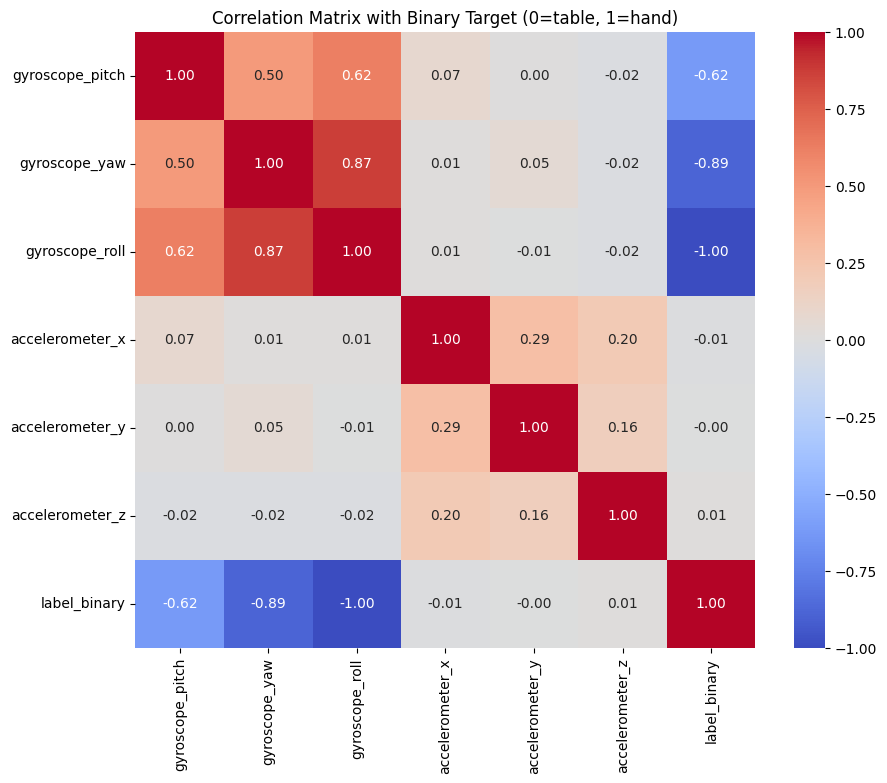


Interpretation:
• Values close to 1: Strong positive correlation
• Values close to -1: Strong negative correlation
• Values close to 0: Little to no correlation

Target encoding:
• 0 = table position
• 1 = hand position


In [3]:
# analysis the correlation between the features
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_df = pd.read_csv(data_csv)



# Define features and label
features = data_df.columns[:-1]  # all columns except label

# First convert the label column to binary (0 for 'table', 1 for 'hand')
data_df['label_binary'] = (data_df['label'] == 'hand').astype(int)

# Calculate correlation matrix
corr_matrix = data_df[['gyroscope_pitch', 'gyroscope_yaw', 'gyroscope_roll', 
                       'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 
                       'label_binary']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,  # Show numbers
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Value range
            fmt='.2f')  # Round to 2 decimal places

plt.title('Correlation Matrix with Binary Target (0=table, 1=hand)')
plt.show()

# Print interpretation
print("\nInterpretation:")
print("• Values close to 1: Strong positive correlation")
print("• Values close to -1: Strong negative correlation")
print("• Values close to 0: Little to no correlation")
print("\nTarget encoding:")
print("• 0 = table position")
print("• 1 = hand position")


### Split the data and preparing the sequence data 

In [4]:
# prepare the data for training 
import pandas as pd
import numpy as np


# Define features (X) and target (y)
features = ['gyroscope_pitch', 'gyroscope_yaw', 'gyroscope_roll', 
           'accelerometer_x', 'accelerometer_y', 'accelerometer_z']

# Convert label to binary (0 for 'table', 1 for 'hand')
data_df['label_binary'] = (data_df['label'] == 'hand').astype(int)

# Get unique session IDs
unique_sessions = data_df['session_id'].unique()

# Split sessions into train and test
from sklearn.model_selection import train_test_split

train_sessions, test_sessions = train_test_split(
    unique_sessions,
    test_size=0.2,
    random_state=42
)

# Split data based on sessions
X_train = data_df[data_df['session_id'].isin(train_sessions)][features]
X_test = data_df[data_df['session_id'].isin(test_sessions)][features]
y_train = data_df[data_df['session_id'].isin(train_sessions)]['label_binary']
y_test = data_df[data_df['session_id'].isin(test_sessions)]['label_binary']

# Print information about the split
print("Dataset Information:")
print(f"Number of training sessions: {len(train_sessions)}")
print(f"Number of testing sessions: {len(test_sessions)}")
print("\nDataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Print class distribution
print("\nClass distribution:")
print("Training set:")
print(y_train.value_counts(normalize=True))
print("\nTesting set:")
print(y_test.value_counts(normalize=True))

# Print session distribution
print("\nSessions in training set:", sorted(train_sessions))
print("Sessions in testing set:", sorted(test_sessions))

# Optional: Group statistics
print("\nData points per session:")
session_stats = data_df.groupby('session_id').size()
print(session_stats.describe())

# Verify no session overlap
train_set = set(X_train.index)
test_set = set(X_test.index)
overlap = train_set.intersection(test_set)
print("\nNumber of overlapping data points:", len(overlap))







Dataset Information:
Number of training sessions: 239
Number of testing sessions: 60

Dataset shapes:
X_train: (150066, 6)
X_test: (37500, 6)
y_train: (150066,)
y_test: (37500,)

Class distribution:
Training set:
1    0.512614
0    0.487386
Name: label_binary, dtype: float64

Testing set:
0    0.546667
1    0.453333
Name: label_binary, dtype: float64

Sessions in training set: [1731663716, 1731663717, 1731663718, 1731663719, 1731663720, 1731663722, 1731663724, 1731663726, 1731663727, 1731663728, 1731663729, 1731663730, 1731663731, 1731663732, 1731663734, 1731663735, 1731663736, 1731663737, 1731663738, 1731663739, 1731663742, 1731663743, 1731663744, 1731663745, 1731663746, 1731663747, 1731663748, 1731663750, 1731663751, 1731663752, 1731663753, 1731663754, 1731663755, 1731663756, 1731663757, 1731663759, 1731663760, 1731663763, 1731663764, 1731663765, 1731663766, 1731663767, 1731663768, 1731663769, 1731663770, 1731663771, 1731663772, 1731663774, 1731663777, 1731663778, 1731663780, 1731663

2024-11-17 00:33:56,535 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Original session counts:
session_id
1731663716    500
1731663717    500
1731663718    500
1731663719    500
1731663720    500
             ... 
1731664010    500
1731664011    500
1731664012    500
1731664013    500
1731664014    426
Length: 299, dtype: int64

Number of sessions with exactly 500 points: 221

After filtering - count per session:
label       hand  table
session_id             
1731663716     0    500
1731663717     0    500
1731663718     0    500
1731663719     0    500
1731663720     0    500
...          ...    ...
1731664009   500      0
1731664010   500      0
1731664011   500      0
1731664012   500      0
1731664013   500      0

[221 rows x 2 columns]

Summary:
Original number of sessions: 299
Number of sessions after filtering: 221
Original number of data points: 187566
Number of data points after filtering: 110500

Final Dataset Information:
Training set shape: (88000, 6)
Testing set shape: (22500, 6)


2024-11-17 00:33:56,585 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


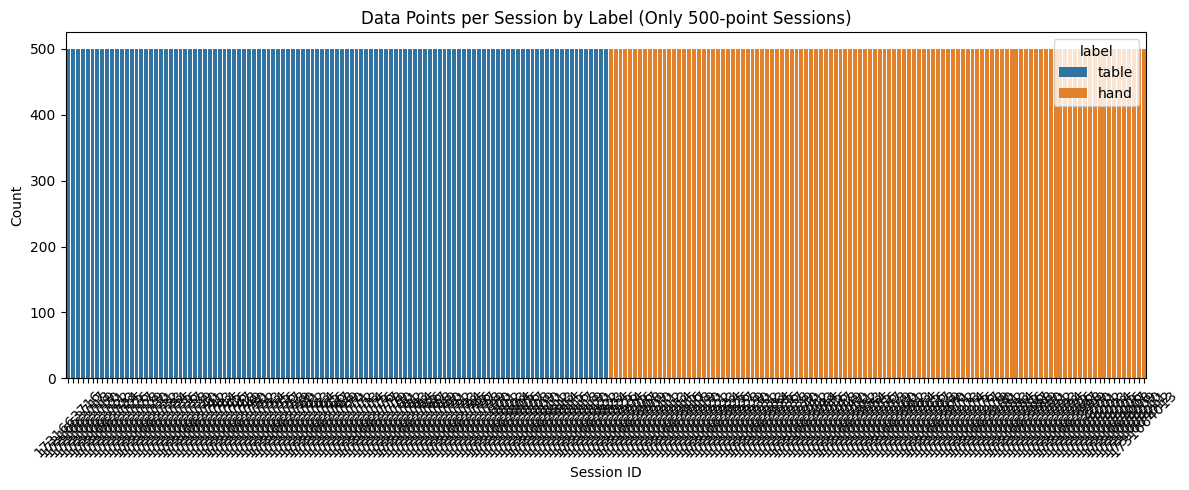

In [5]:
# First, get the count of data points per session
session_counts = data_df.groupby('session_id').size()
print("Original session counts:")
print(session_counts)

# Find sessions with exactly 500 points
valid_sessions = session_counts[session_counts == 500].index
print(f"\nNumber of sessions with exactly 500 points: {len(valid_sessions)}")

# Filter the dataframe to keep only those sessions
filtered_df = data_df[data_df['session_id'].isin(valid_sessions)].copy()

# Verify the filtering
print("\nAfter filtering - count per session:")
print(filtered_df.groupby(['session_id', 'label']).size().unstack(fill_value=0))

# Print summary
print("\nSummary:")
print(f"Original number of sessions: {len(data_df['session_id'].unique())}")
print(f"Number of sessions after filtering: {len(filtered_df['session_id'].unique())}")
print(f"Original number of data points: {len(data_df)}")
print(f"Number of data points after filtering: {len(filtered_df)}")

# Update your X and y with filtered data
features = ['gyroscope_pitch', 'gyroscope_yaw', 'gyroscope_roll', 
           'accelerometer_x', 'accelerometer_y', 'accelerometer_z']

# Convert label to binary (0 for 'table', 1 for 'hand')
filtered_df['label_binary'] = (filtered_df['label'] == 'hand').astype(int)

# Split sessions into train and test
unique_sessions = filtered_df['session_id'].unique()
train_sessions, test_sessions = train_test_split(
    unique_sessions,
    test_size=0.2,
    random_state=42
)

# Split data based on sessions
X_train = filtered_df[filtered_df['session_id'].isin(train_sessions)][features]
X_test = filtered_df[filtered_df['session_id'].isin(test_sessions)][features]
y_train = filtered_df[filtered_df['session_id'].isin(train_sessions)]['label_binary']
y_test = filtered_df[filtered_df['session_id'].isin(test_sessions)]['label_binary']

# Print final dataset information
print("\nFinal Dataset Information:")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Visualize the final distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=filtered_df, x='session_id', hue='label')
plt.title('Data Points per Session by Label (Only 500-point Sessions)')
plt.xlabel('Session ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Convert to sequence

In [6]:
def prepare_sequence_data(df, features, sequence_length=500):
    """
    Prepare sequence data from DataFrame, grouping by session_id.
    """
    # Initialize lists to store sequences and labels
    sequences = []
    labels = []
    
    # Group by session_id and sort by index within each group
    for session_id in df['session_id'].unique():
        # Get data for this session
        session_data = df[df['session_id'] == session_id].sort_index()
        
        if len(session_data) == sequence_length:
            # Extract features
            sequence = session_data[features].values
            # Get the label (assuming all rows in a session have same label)
            label = session_data['label_binary'].iloc[0]
            
            sequences.append(sequence)
            labels.append(label)
    
    # Convert to numpy arrays
    X = np.array(sequences)
    y = np.array(labels)
    
    print(f"Prepared sequences shape: {X.shape}")
    print(f"Prepared labels shape: {y.shape}")
    
    return X, y



2024-11-17 00:34:07,422 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-17 00:34:07,482 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Prepared sequences shape: (176, 500, 6)
Prepared labels shape: (176,)
Prepared sequences shape: (45, 500, 6)
Prepared labels shape: (45,)

Final Dataset Information:
Training set shape: (176, 500, 6)
Testing set shape: (45, 500, 6)
Training labels shape: (176,)
Testing labels shape: (45,)


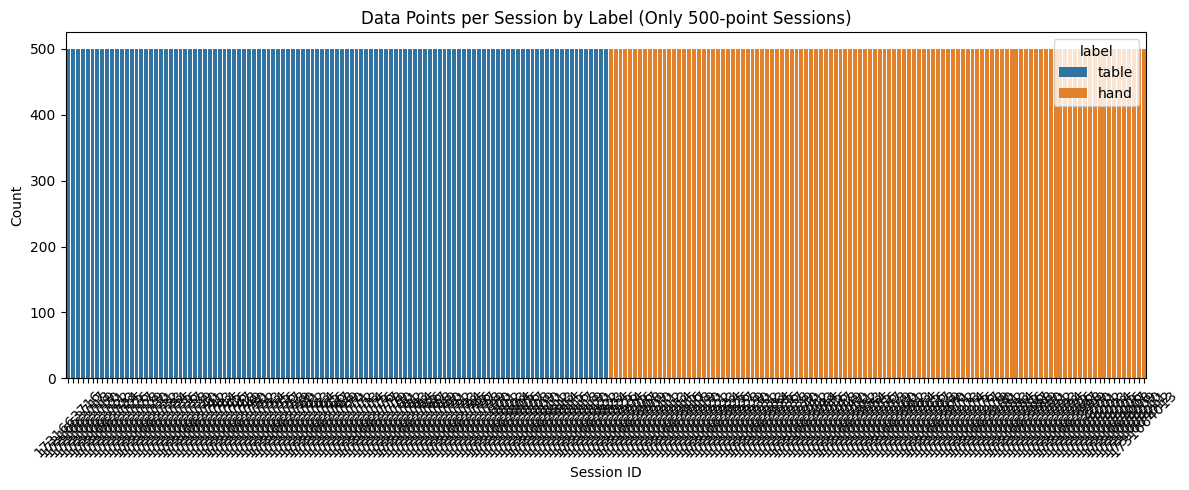

In [7]:
# Replace the old code with this:
# Prepare training and testing sequences
X_train_seq, y_train_seq = prepare_sequence_data(
    filtered_df[filtered_df['session_id'].isin(train_sessions)],
    features
)

X_test_seq, y_test_seq = prepare_sequence_data(
    filtered_df[filtered_df['session_id'].isin(test_sessions)],
    features
)

# Print final dataset information
print("\nFinal Dataset Information:")
print(f"Training set shape: {X_train_seq.shape}")  # Will show (n_train_sessions, 500, 6)
print(f"Testing set shape: {X_test_seq.shape}")    # Will show (n_test_sessions, 500, 6)
print(f"Training labels shape: {y_train_seq.shape}")  # Will show (n_train_sessions,)
print(f"Testing labels shape: {y_test_seq.shape}")    # Will show (n_test_sessions,)

# Visualize the final distribution (keep this part)
plt.figure(figsize=(12, 5))
sns.countplot(data=filtered_df, x='session_id', hue='label')
plt.title('Data Points per Session by Label (Only 500-point Sessions)')
plt.xlabel('Session ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Define model

In [8]:
# RNN model for classification by using the 500 data points as one session and the label as the target/ using session_id as the identifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd
import numpy as np



# using 'session_id' as group identifier to build sequency 

#Long Short-Term Memory 
def define_LST_model(input_shape):
    """
    Define a sequential model for sequence classification.

    Parameters:
        input_shape (tuple): Shape of the input data (sequence_length, num_features).

    Returns:
        model (Sequential): Defined Keras model.
    """
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")  # Use 'softmax' for multi-class classification
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


def train_models(model, X_train, y_train, X_val, y_val, 
                batch_size=32, 
                epochs=50,
                patience=10,
                verbose=1):
    """
    Train and evaluate a model with early stopping and model checkpointing.
    
    Parameters:
    - model: The compiled keras model
    - X_train: Training features
    - y_train: Training labels
    - X_val: Validation features
    - y_val: Validation labels
    - batch_size: Batch size for training (default: 32)
    - epochs: Maximum number of epochs (default: 50)
    - patience: Early stopping patience (default: 10)
    - verbose: Verbosity level (default: 1)
    
    Returns:
    - history: Training history
    - model: Trained model
    """
    
    # Create callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    
    # Model checkpoint callback
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',  # Changed from .h5 to .keras
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint],
        verbose=verbose
    )
    
    # This part is more flexible
    train_metrics = model.evaluate(X_train, y_train, verbose=0)
    val_metrics = model.evaluate(X_val, y_val, verbose=0)
    
    # Get metric names
    metric_names = ['loss', 'accuracy']  # Basic metrics
    
    # Print results using dictionary comprehension
    train_results = dict(zip(metric_names, train_metrics))
    val_results = dict(zip(metric_names, val_metrics))
    
    # Print results
    print("\nTraining Results:")
    for metric_name, value in train_results.items():
        print(f"Train {metric_name}: {value:.4f}")
    
    print("\nValidation Results:")
    for metric_name, value in val_results.items():
        print(f"Validation {metric_name}: {value:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return history, model

# Example usage:
"""
# First split your data
from sklearn.model_selection import train_test_split

X = data_df[['gyroscope_pitch', 'gyroscope_yaw', 'gyroscope_roll', 
             'accelerometer_x', 'accelerometer_y', 'accelerometer_z']]
y = data_df['label_binary']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train model
model = create_model()
history, trained_model = train_models(
    model,
    X_train, y_train,
    X_val, y_val,
    batch_size=32,
    epochs=50,
    patience=10
)
"""


"\n# First split your data\nfrom sklearn.model_selection import train_test_split\n\nX = data_df[['gyroscope_pitch', 'gyroscope_yaw', 'gyroscope_roll', \n             'accelerometer_x', 'accelerometer_y', 'accelerometer_z']]\ny = data_df['label_binary']\n\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Create and train model\nmodel = create_model()\nhistory, trained_model = train_models(\n    model,\n    X_train, y_train,\n    X_val, y_val,\n    batch_size=32,\n    epochs=50,\n    patience=10\n)\n"

In [9]:
# check the shape of X_train, y_train, X_test, y_test
print(X_train_seq.shape)
print(y_train_seq.shape)
print(X_test_seq.shape)
print(y_test_seq.shape)

(176, 500, 6)
(176,)
(45, 500, 6)
(45,)


Epoch 1/50


C:\Users\lycaz\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.0808 - loss: 0.7763 - val_accuracy: 1.0000 - val_loss: 0.6500
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9144 - loss: 0.6312 - val_accuracy: 1.0000 - val_loss: 0.5540
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.5371 - val_accuracy: 1.0000 - val_loss: 0.4522
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.4303 - val_accuracy: 1.0000 - val_loss: 0.3482
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.3341 - val_accuracy: 1.0000 - val_loss: 0.2547
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.2422 - val_accuracy: 1.0000 - val_loss: 0.1785
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.1732 - val_accuracy: 1.0000 - val_loss: 0.1210
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 0.1172 - val_accuracy: 1.0000 - val_loss: 0.0823
Epo

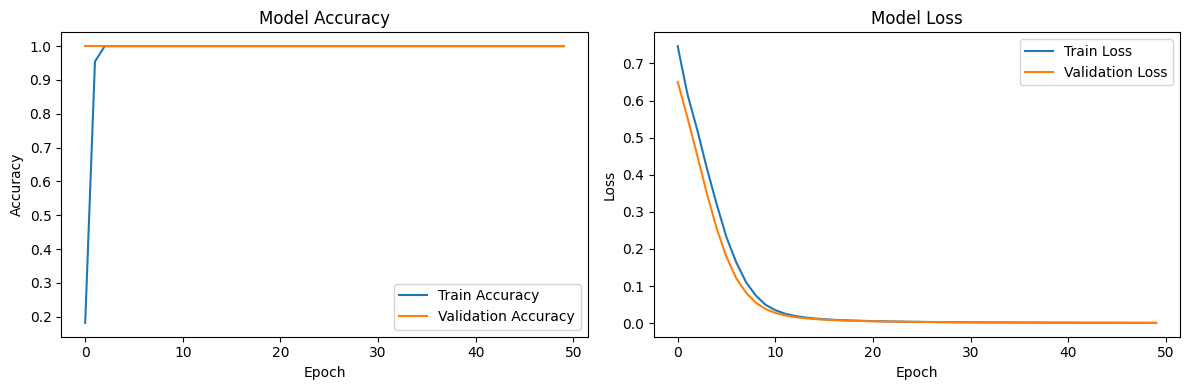

In [10]:
lst_model=define_LST_model((500, 6))

lst_history, lst_model = train_models(lst_model, X_train_seq, y_train_seq, X_test_seq, y_test_seq,
                batch_size=32, 
                epochs=50,
                patience=10,
                verbose=1)

#### Inference the model 

In [16]:
import pydualsense as ds
import time

def get_a_sequence_data(ds,sequence_length=500):
    # get the inertial data from the dualsense controller
    count = 0 
    sequence_data=[]
    while count < sequence_length:
        gyro = ds.state.gyro
        accel = ds.state.accelerometer
        data_point = [
            gyro.Pitch, gyro.Yaw, gyro.Roll,
            accel.X, accel.Y, accel.Z
        ]
        sequence_data.append(data_point)
        count += 1
    
    return sequence_data




    


def perform_classification(model, perform_duration=60000):
    """
    Perform real-time classification for a specified duration.
    
    Parameters:
    - model: Trained LSTM model
    - perform_duration: Duration to run in milliseconds (default: 100000 ms = 100 seconds)
    """
    # Initialize the controller
    dualsense = ds.pydualsense()
    dualsense.init()

    # Get start time
    start_time = time.time()
    
    print(f"Starting classification for {perform_duration/1000:.1f} seconds...")
    
    try:
        while (time.time() - start_time) * 1000 < perform_duration:
            # Get the inertial data from the dualsense controller
            inertial_data = get_a_sequence_data(dualsense)
            
            # Predict the gesture (reshape for LSTM input if needed)
            inertial_data = np.array(inertial_data).reshape(1, 500, 6)  # Reshape to (1, sequence_length, features)
            gesture = model.predict(inertial_data, verbose=0)
            
            # Convert prediction to label
            predicted_label = "hand" if gesture[0][0] > 0.5 else "table"
            
            # Calculate elapsed time
            elapsed_time = time.time() - start_time
            
            # Print the prediction with timestamp
            print(f"Time: {elapsed_time:.2f}s, Prediction: {predicted_label} (confidence: {gesture[0][0]:.2f})", end='\r')
            
            # Small delay to prevent overwhelming the controller
            time.sleep(0.001)
            
    except KeyboardInterrupt:
        print("\nClassification interrupted by user")
    finally:
        # Clean up
        dualsense.close()
        print("\nClassification completed")

# Example usage:
# perform_classification(trained_model, perform_duration=10000)  # Run for 10 seconds
    

In [17]:
perform_classification(lst_model)

Starting classification for 60.0 seconds...
Time: 60.02s, Prediction: hand (confidence: 1.00))
Classification completed


## Grip features analysis

### Sound wave analysis

In [50]:
# Spectrograms 


import pydualsense as ds 
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import plotly.graph_objects as go
from scipy.signal import spectrogram
import time
import plotly.io as pio
pio.renderers.default = "notebook"

def list_audio_devices():
    """List all available audio devices"""
    p = pyaudio.PyAudio()
    info = []
    
    print("\nAvailable Audio Devices:")
    print("-" * 60)
    
    for i in range(p.get_device_count()):
        dev_info = p.get_device_info_by_index(i)
        if dev_info['maxInputChannels'] > 0:  # Only show input devices
            print(f"Index: {i}")
            print(f"Name: {dev_info['name']}")
            print(f"Channels: {dev_info['maxInputChannels']}")
            print(f"Sample Rate: {dev_info['defaultSampleRate']}")
            print("-" * 60)
            info.append(dev_info)
    
    p.terminate()
    return info

def search_dualsense_mic():
    """Search for DualSense microphone and verify device functionality"""
    try:
        pa = pyaudio.PyAudio()
        dualsense_index = None
        
        # First find all input devices
        for i in range(pa.get_device_count()):
            dev = pa.get_device_info_by_index(i)
            if dev['maxInputChannels'] > 0:
                if "dualsense" in dev['name'].lower():
                    # Try to open a test stream to verify device works
                    try:
                        test_stream = pa.open(
                            format=pyaudio.paInt16,
                            channels=1,
                            rate=int(dev['defaultSampleRate']),
                            input=True,
                            input_device_index=i,
                            frames_per_buffer=1024
                        )
                        test_stream.close()
                        print(f"Found working DualSense device: {dev['name']}")
                        print(f"Device index: {i}")
                        print(f"Sample rate: {int(dev['defaultSampleRate'])} Hz")
                        print(f"Input channels: {dev['maxInputChannels']}")
                        dualsense_index = i
                        break
                    except Exception:
                        print(f"Found DualSense device at index {i} but it appears non-functional")
                        continue
        
        pa.terminate()
        
        if dualsense_index is None:
            print("No working DualSense microphone found")
            return None
            
        return dualsense_index
        
    except Exception as e:
        print(f"Error searching for DualSense mic: {str(e)}")
        return None

def get_dualsense_audio_realtime_plotly(duration=10, rate=48000, chunk=1024):
    """Capture and plot audio in real-time with Plotly, updating a single image"""
    try:
        # Initialize PyAudio
        pa = pyaudio.PyAudio()
        
        # Find DualSense mic
        mic_index = search_dualsense_mic()
        if mic_index is None:
            print("Could not find DualSense microphone!")
            return None
        
        # Get device info
        device_info = pa.get_device_info_by_index(mic_index)
        print(f"\nUsing device: {device_info['name']}")
        
        # Generate initial spectrogram dimensions
        dummy_audio = np.zeros(chunk, dtype=np.int16)
        f, t, Sxx = spectrogram(dummy_audio, fs=rate, nperseg=512, noverlap=384)
        z_data = np.zeros((len(f), 100))
        
        # Initialize Plotly figure with wider layout
        fig = go.FigureWidget(
            data=[go.Heatmap(
                z=z_data,
                colorscale="Viridis",
                zmin=-100,  # Set reasonable limits for audio data
                zmax=0,
            )],
            layout=go.Layout(
                title="Real-Time Audio Spectrogram",
                xaxis=dict(title="Time (Frames)"),
                yaxis=dict(
                    title="Frequency (Hz)", 
                    type='log',
                    range=[np.log10(1), np.log10(30000)],  # Set range from 0 to 30kHz
                    tickmode='array',
                    tickvals=np.logspace(0, np.log10(30000), 10),
                    ticktext=[f"{x:.0f}" for x in np.logspace(0, np.log10(30000), 10)]
                ),
                width=1000,
                height=600
            )
        )
        
        display(fig)  # Use display instead of show for Jupyter
        
        # Open stream
        try:
            stream = pa.open(
                format=pyaudio.paInt16,
                channels=1,
                rate=rate,
                input=True,
                input_device_index=mic_index,
                frames_per_buffer=chunk
            )
        except OSError as e:
            print(f"Error opening stream: {e}")
            pa.terminate()
            return None
            
        print("\nRecording and plotting in realtime...")
        start_time = time.time()
        
        try:
            while time.time() - start_time < duration:
                # Read audio data
                data = stream.read(chunk, exception_on_overflow=False)
                audio_chunk = np.frombuffer(data, dtype=np.int16)
                
                # Generate spectrogram
                f, t, Sxx = spectrogram(audio_chunk, fs=rate, nperseg=512, noverlap=384)
                
                # Convert to dB scale with proper normalization
                Sxx_db = 10 * np.log10(Sxx + 1e-10)  # Avoid log(0)
                
                # Update rolling buffer
                z_data = np.roll(z_data, -1, axis=1)
                z_data[:, -1] = np.mean(Sxx_db, axis=1)
                
                # Update plot with new data
                fig.data[0].z = z_data
                
                # Force plot refresh
                fig.update_layout(dict(title="Real-Time Audio Spectrogram"))
                
        except Exception as e:
            print(f"Error during recording: {e}")
        
        finally:
            stream.stop_stream()
            stream.close()
            pa.terminate()
            
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None



In [52]:
list_audio_devices()


Available Audio Devices:
------------------------------------------------------------
Index: 0
Name: Microsoft Sound Mapper - Input
Channels: 2
Sample Rate: 44100.0
------------------------------------------------------------
Index: 1
Name: 麦克风 (Logitech StreamCam)
Channels: 2
Sample Rate: 44100.0
------------------------------------------------------------
Index: 2
Name: 麦克风 (Steam Streaming Microphone
Channels: 8
Sample Rate: 44100.0
------------------------------------------------------------
Index: 3
Name: 耳机 (2- WH-CH520)
Channels: 1
Sample Rate: 44100.0
------------------------------------------------------------
Index: 4
Name: 耳机式麦克风 (2- DualSense Wireless C
Channels: 2
Sample Rate: 44100.0
------------------------------------------------------------
Index: 12
Name: Primary Sound Capture Driver
Channels: 2
Sample Rate: 44100.0
------------------------------------------------------------
Index: 13
Name: 麦克风 (Logitech StreamCam)
Channels: 2
Sample Rate: 44100.0
------------------

[{'index': 0,
  'structVersion': 2,
  'name': 'Microsoft Sound Mapper - Input',
  'hostApi': 0,
  'maxInputChannels': 2,
  'maxOutputChannels': 0,
  'defaultLowInputLatency': 0.09,
  'defaultLowOutputLatency': 0.09,
  'defaultHighInputLatency': 0.18,
  'defaultHighOutputLatency': 0.18,
  'defaultSampleRate': 44100.0},
 {'index': 1,
  'structVersion': 2,
  'name': '麦克风 (Logitech StreamCam)',
  'hostApi': 0,
  'maxInputChannels': 2,
  'maxOutputChannels': 0,
  'defaultLowInputLatency': 0.09,
  'defaultLowOutputLatency': 0.09,
  'defaultHighInputLatency': 0.18,
  'defaultHighOutputLatency': 0.18,
  'defaultSampleRate': 44100.0},
 {'index': 2,
  'structVersion': 2,
  'name': '麦克风 (Steam Streaming Microphone',
  'hostApi': 0,
  'maxInputChannels': 8,
  'maxOutputChannels': 0,
  'defaultLowInputLatency': 0.09,
  'defaultLowOutputLatency': 0.09,
  'defaultHighInputLatency': 0.18,
  'defaultHighOutputLatency': 0.18,
  'defaultSampleRate': 44100.0},
 {'index': 3,
  'structVersion': 2,
  'name':

In [16]:
#ISSUE: INDEX CHOOSING MANULY
# Simple test of specific device
def test_specific_dualsense(index):
    pa = pyaudio.PyAudio()
    try:
        stream = pa.open(
            format=pyaudio.paInt16,
            channels=2,
            rate=48000,
            input=True,
            input_device_index=index,
            frames_per_buffer=1024
        )
        print(f"Successfully opened device {index}")
        stream.stop_stream()
        stream.close()
        return True
    except Exception as e:
        print(f"Failed to open device {index}: {e}")
        return False
    finally:
        pa.terminate()

# Test index 36 (the most likely to work based on your output)
test_specific_dualsense(16)

Successfully opened device 16


True

In [51]:
# Example usage:
get_dualsense_audio_realtime_plotly()

Found DualSense device at index 4 but it appears non-functional
Found working DualSense device: 耳机式麦克风 (2- DualSense Wireless Controller)
Device index: 16
Sample rate: 44100 Hz
Input channels: 2

Using device: 耳机式麦克风 (2- DualSense Wireless Controller)


FigureWidget({
    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                             [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                             '#31688e'], [0.4444444444444444, '#26828e'],
                             [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                             '#35b779'], [0.7777777777777778, '#6ece58'],
                             [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
              'type': 'heatmap',
              'uid': 'bb4d6c0a-352d-47e5-bbe9-2262b33d5340',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]]),
              'zmax': 0,
              'z


Recording and plotting in realtime...
